In [43]:
import torch
import pickle 
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import matplotlib as mpl
import copy
import sys
import matplotlib as mpl
from sklearn.cluster import KMeans
from scipy.ndimage import gaussian_filter, binary_opening, binary_closing
from scipy.stats import entropy
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, spearmanr
from skimage.metrics import structural_similarity as ssim
from scipy.special import kl_div
from scipy.stats import wasserstein_distance
from matplotlib import gridspec


# Get the parent directory of the current directory
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)
    
from diffusion_proc import Diffusion, linear_noise_schedule
from unet import Unet
from dataset import CondSeqImageDataset

VOL_PATH = "/vol/bitbucket/ag323"

In [2]:
DATA_DIR = os.path.join(VOL_PATH, "diss_ag/data/frame_data_dist") #"C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/data/evaluation_data"
MODEL_PATH = os.path.join(VOL_PATH, "diss_ag/results/ckpts/gde_ensemble_model_4_64x64_simData_10000samples_fixedParams.pt") # "C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/results/ckpts/gde_ensemble_model_4_64x64_simData_10000samples_fixedParams.pt"

(64, 64)


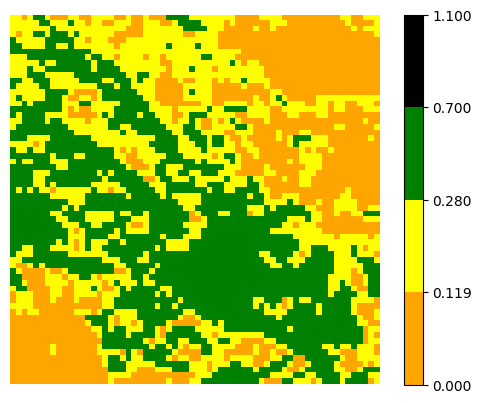

In [3]:
# custormize colorbar
cmap = mpl.colors.ListedColormap(['orange','yellow', 'green', 'black'])
cmap.set_over('0.25')
cmap.set_under('0.75')
bounds =  [0.0,0.1188,0.2798,0.7,1.1] #[0.0,0.2488,0.3098,0.7,1.1] # [1.0, 2.02, 2.27, 3.5, 5.1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

BACKGROUND_PATH = os.path.join(VOL_PATH, "diss_ag/data/background.mpy") # "C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/
with open(BACKGROUND_PATH, 'rb') as f:
    background_img = pickle.load(f)
    print(background_img.shape)

plt.imshow(background_img, cmap=cmap, norm=norm)
plt.colorbar()
plt.axis("off")
plt.show()

# binary custom cmap
binary_cmap = mpl.colors.ListedColormap(['cyan', 'yellow'])

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
diff_model =  Unet(
    in_ch=1,
    cond_ch=1,
    model_ch=96,
    output_ch=1,
    channel_mult=(1, 2, 2),
    attn_res=[],
)
diff_model.load_state_dict(torch.load(MODEL_PATH))
diff_model.to(device)

Unet(
  (time_emb): Sequential(
    (0): Linear(in_features=96, out_features=384, bias=True)
    (1): SiLU()
    (2): Linear(in_features=384, out_features=384, bias=True)
  )
  (downsample_blocks): ModuleList(
    (0): TimestepSeqEmbedding(
      (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x TimestepSeqEmbedding(
      (0): ResBlock(
        (conv_1): Sequential(
          (0): GroupNorm(32, 96, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (time_embedding): Sequential(
          (0): SiLU()
          (1): Linear(in_features=384, out_features=96, bias=True)
        )
        (condition_conv): Sequential(
          (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): SiLU()
        )
        (conv_2): Sequential(
          (0): GroupNorm(32, 96, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(

In [5]:
transform = transforms.Compose([
    transforms.ToTensor()
])

simulation_data = CondSeqImageDataset(os.path.join(DATA_DIR, "state_1"), transform=transform)

In [31]:
def mean_result(sample_arr):
    stacked_arrays = np.stack(sample_arr)
    mean_array = np.mean(stacked_arrays, axis=0)
    return mean_array

def mean_aggregated_result(sample_arr):
    stacked_arrays = np.array(sample_arr)
    mean_array = np.mean(stacked_arrays, axis=0)
    return mean_array

def calc_mean_dist_timesteps(data):
    t_s = [0, 5, 10, 15]
    mean_dists = []
    for i in t_s:
        data_arr = []
        data_arr_secondary = []
        for idx in range(i, len(data), 16):
            t_plus_5, t = data[idx]
            if i != 15:
                data_arr.append(t.squeeze().numpy())
            else:
                data_arr.append(t.squeeze().numpy())
                data_arr_secondary.append(t_plus_5.squeeze().numpy())

        if i == 0:
            mean_dists.append(data_arr[0])
        else:
            mean_dists.append(mean_result(data_arr))
    
        if len(data_arr_secondary) > 0:
            mean_dists.append(mean_result(data_arr_secondary))
            
    return mean_dists

In [40]:
# def plot_dist(images, type_output="simulation"):
#     """
#     Plots 5 images in a row using matplotlib and displays a shared colorbar below the plot.

#     Parameters:
#     images (list of ndarray): List of 5 images (each image as a numpy array).

#     """
#     fig, axes = plt.subplots(1, 5, figsize=(15, 3))  # Create a figure with 5 subplots in a row
    
#     # Display each image
#     for i, ax in enumerate(axes):
#         img = ax.imshow(images[i], cmap="hot_r")  # Display each image
#         if type_output == "simulation":
#             if i == 0:
#                 ax.set_title(f"Initial State t = {i}")
#             else:
#                 ax.set_title(f"Simulated Distribution t = {i*5}")
#         else:
#             if i == 0:
#                 ax.set_title(f"Initial State t = {i}")
#             else:
#                 ax.set_title(f"Predicted Distribution t = {i*5}")
#         ax.axis('off')  # Hide axes

#     # Add a shared colorbar
#     cbar = fig.colorbar(img, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1)
#     cbar.set_label("Intensity")  # You can set a label for the colorbar

#     plt.tight_layout()
#     plt.show()

def plot_dist(images, type_output="simulation"):
    """
    Plots 5 images in a row using matplotlib and displays a shared colorbar below or beside the plot.

    Parameters:
    images (list of ndarray): List of 5 images (each image as a numpy array).
    """

    fig = plt.figure(figsize=(15, 3))  # Create a figure with the desired size
    gs = gridspec.GridSpec(1, 6, width_ratios=[1, 1, 1, 1, 1, 0.05])  # Define grid, last column for the colorbar
    
    axes = [fig.add_subplot(gs[i]) for i in range(5)]  # Create subplots in the grid

    # Display each image
    for i, ax in enumerate(axes):
        img = ax.imshow(images[i], cmap="hot_r")  # Display each image
        if type_output == "simulation":
            if i == 0:
                ax.set_title(f"Initial State t = {i}")
            else:
                ax.set_title(f"Simulated Distribution t = {i*5}")
        else:
            if i == 0:
                ax.set_title(f"Initial State t = {i}")
            else:
                ax.set_title(f"Predicted Distribution t = {i*5}")
        ax.axis('off')  # Hide axes

    # Add a shared colorbar in the last grid cell
    cbar_ax = fig.add_subplot(gs[5])
    fig.colorbar(img, cax=cbar_ax)

    plt.tight_layout()
    plt.show()

def kl_divergence(distribution1, distribution2):
    distribution1, _ = np.histogram(distribution1.flatten(), bins=256, range=(0, 1), density=True)
    distribution2, _ = np.histogram(distribution2.flatten(), bins=256, range=(0, 1), density=True)
    
    # Ensure there are no zero values to avoid division by zero in KL divergence computation
    distribution1 = np.where(distribution1 == 0, 1e-10, distribution1)
    distribution2 = np.where(distribution2 == 0, 1e-10, distribution2)
    
    return entropy(distribution1, distribution2)

In [41]:
diffusion = Diffusion(timesteps=500, noise_schedule='linear')

def generate_predictions(t_0, diff_client, num_preds=4):
    
    input_img = t_0

    input_img = input_img.to(device).float().unsqueeze(0)
    image_size = input_img.shape[-1]
    channels = input_img.shape[1]

    mean_outputs = []
    all_outputs = []
    for idx in range(10):
        input_arr = [input_img]
        outputs = []
        for i in range(num_preds):
            generated_images = diff_client.sample(
                model=diff_model,
                image_size=image_size,
                cond_img=input_arr[-1],
                batch_size=1,  # Set the desired batch size
                channels=channels,
                w=2,
                clip_denoised=True
            )

            otpt = generated_images[-1].squeeze().squeeze()
            otpt = np.where(otpt <= 0.5, 0, otpt)
            otpt = np.where(otpt > 0.5, 1, otpt)

            outputs.append(otpt)
            
            next_input = transform(otpt).to(device).float().unsqueeze(0)
            input_arr.append(next_input)

        all_outputs.append(outputs)

    return mean_aggregated_result(all_outputs)

def compare_probability_maps(pred_map, true_map):
    # Mean Squared Error
    mse = mean_squared_error(true_map, pred_map)
    
    # Root Mean Squared Error
    rmse = np.sqrt(mse)
    
    # Mean Absolute Error
    mae = mean_absolute_error(true_map, pred_map)
    
    # Pearson Correlation Coefficient
    pearson_corr, _ = pearsonr(true_map.flatten(), pred_map.flatten())
    
    # Spearman Correlation Coefficient
    spearman_corr, _ = spearmanr(true_map.flatten(), pred_map.flatten())
    
    # Structural Similarity Index (SSIM)
    ssim_index, _ = ssim(true_map, pred_map, data_range=true_map.max() - true_map.min(), full=True)
    
    # Kullback-Leibler Divergence (add small epsilon to avoid log(0))
    kl_divergence = np.sum(kl_div(true_map + 1e-10, pred_map + 1e-10))
    
    # Earth Mover’s Distance (1D Flattened arrays)
    emd = wasserstein_distance(true_map.flatten(), pred_map.flatten())
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'Pearson Correlation': pearson_corr,
        'Spearman Correlation': spearman_corr,
        'SSIM': ssim_index,
        'KL Divergence': kl_divergence,
        'EMD (Wasserstein Distance)': emd
    }

sampling loop time step: 100%|████████████████████████████████████████████████████████████| 500/500 [00:15<00:00, 33.32it/s]


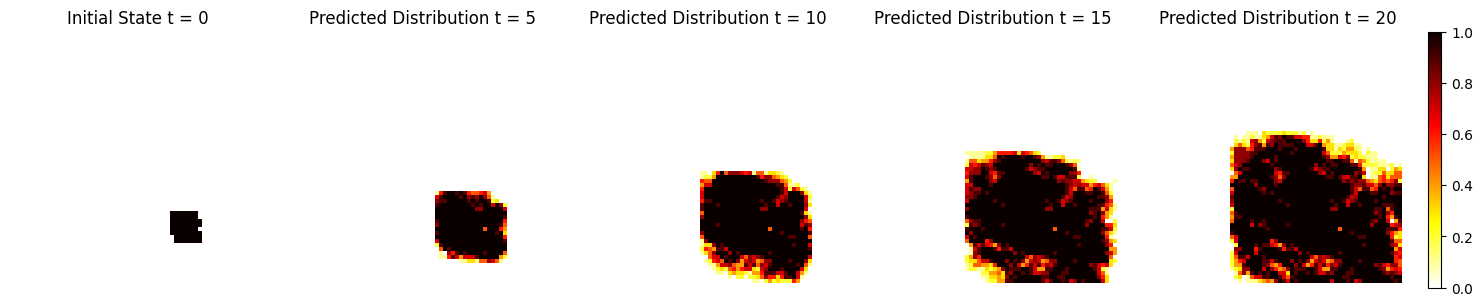

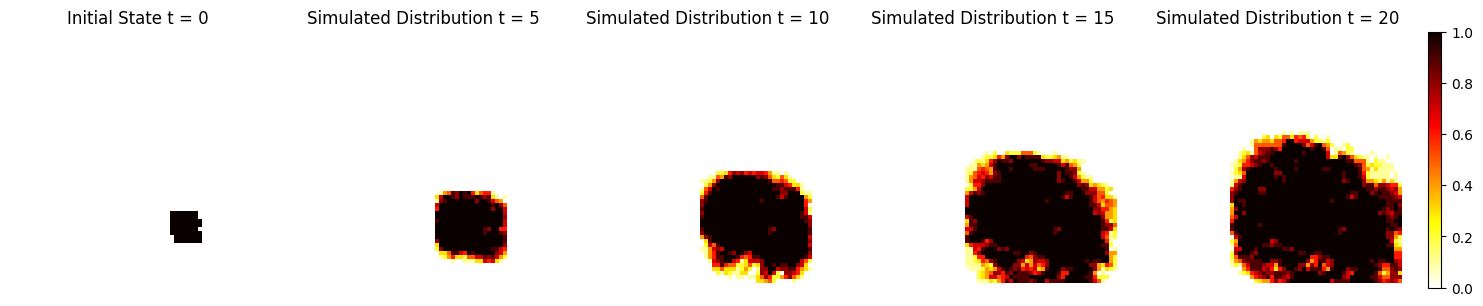

{'MSE': 0.04853515604227142, 'RMSE': 0.2203069586787295, 'MAE': 0.051904296788052307, 'Pearson Correlation': 0.4665131638444053, 'Spearman Correlation': 0.4363773092584747, 'SSIM': 0.8397871107189807, 'KL Divergence': 212.5999990607592, 'EMD (Wasserstein Distance)': 0.051904296788052307}
KL Divergence at t=5 : 0.043
{'MSE': 0.06963134744844866, 'RMSE': 0.26387752357570865, 'MAE': 0.0831298828154104, 'Pearson Correlation': 0.6758402616793903, 'Spearman Correlation': 0.6509654345558626, 'SSIM': 0.7489168414742781, 'KL Divergence': 318.225411754405, 'EMD (Wasserstein Distance)': 0.08244628898974042}
KL Divergence at t=10 : 0.043
{'MSE': 0.07632080028437488, 'RMSE': 0.27626219481567665, 'MAE': 0.09870605457435887, 'Pearson Correlation': 0.7716739751740711, 'Spearman Correlation': 0.7791881297138877, 'SSIM': 0.7058128979513734, 'KL Divergence': 348.62133741817735, 'EMD (Wasserstein Distance)': 0.09523925744906592}
KL Divergence at t=15 : 0.035
{'MSE': 0.06707519491901624, 'RMSE': 0.25898879

sampling loop time step: 100%|████████████████████████████████████████████████████████████| 500/500 [00:14<00:00, 33.68it/s]


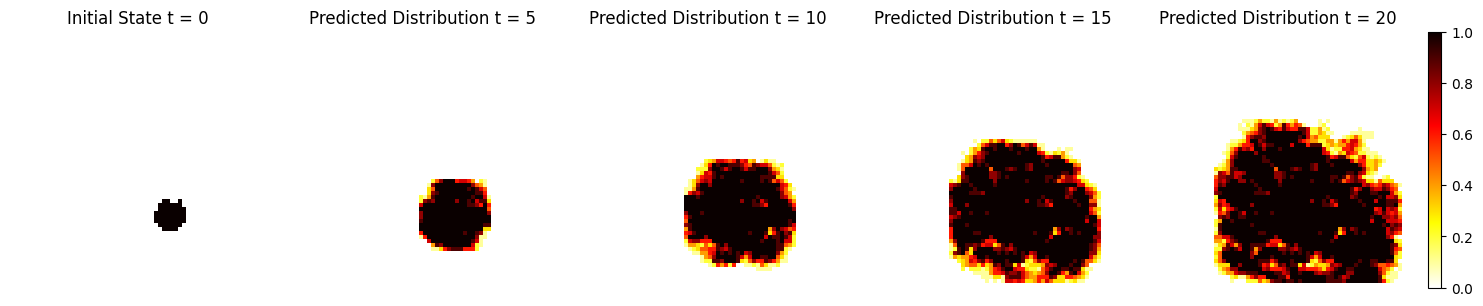

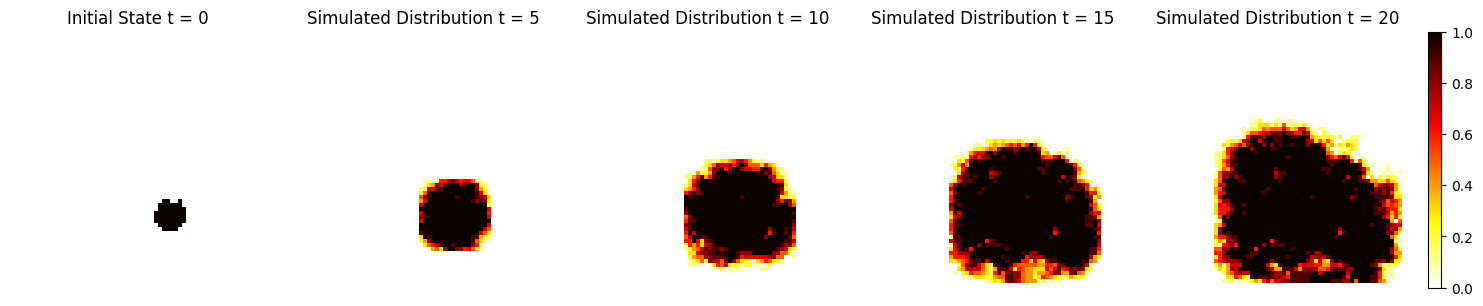

{'MSE': 0.04648437488685886, 'RMSE': 0.21560235362087043, 'MAE': 0.05004882810499112, 'Pearson Correlation': 0.44525036091255665, 'Spearman Correlation': 0.4099330298625239, 'SSIM': 0.8432334920115654, 'KL Divergence': 204.9999993410699, 'EMD (Wasserstein Distance)': 0.05004882810499112}
KL Divergence at t=5 : 0.044
{'MSE': 0.06188720667392773, 'RMSE': 0.24877139440443657, 'MAE': 0.07604980460710067, 'Pearson Correlation': 0.6950481050377282, 'Spearman Correlation': 0.6702510112895055, 'SSIM': 0.7306220806055853, 'KL Divergence': 287.5450932299642, 'EMD (Wasserstein Distance)': 0.07507324206926569}
KL Divergence at t=10 : 0.039
{'MSE': 0.08258789031344352, 'RMSE': 0.28738108899759485, 'MAE': 0.10766601574068774, 'Pearson Correlation': 0.7558949853103027, 'Spearman Correlation': 0.7570264554244953, 'SSIM': 0.6533159583424425, 'KL Divergence': 380.64403265557155, 'EMD (Wasserstein Distance)': 0.10395507795619778}
KL Divergence at t=15 : 0.041
{'MSE': 0.07020996076418673, 'RMSE': 0.264971

sampling loop time step: 100%|████████████████████████████████████████████████████████████| 500/500 [00:14<00:00, 34.38it/s]


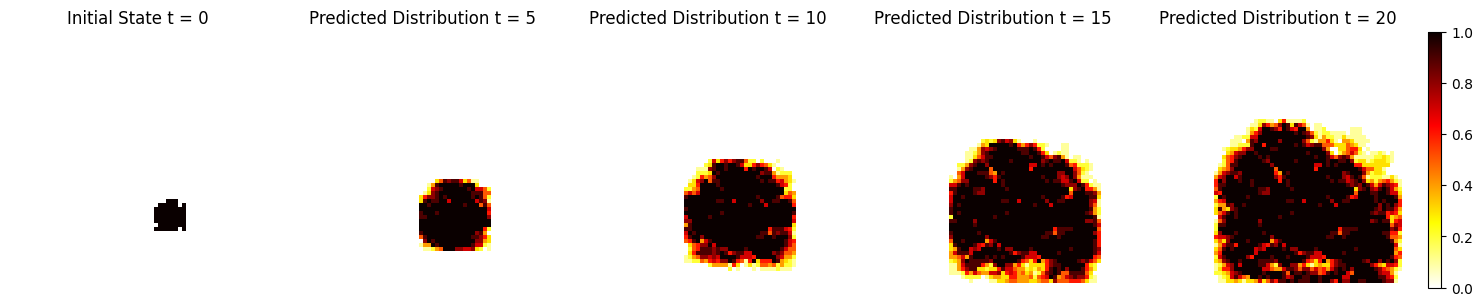

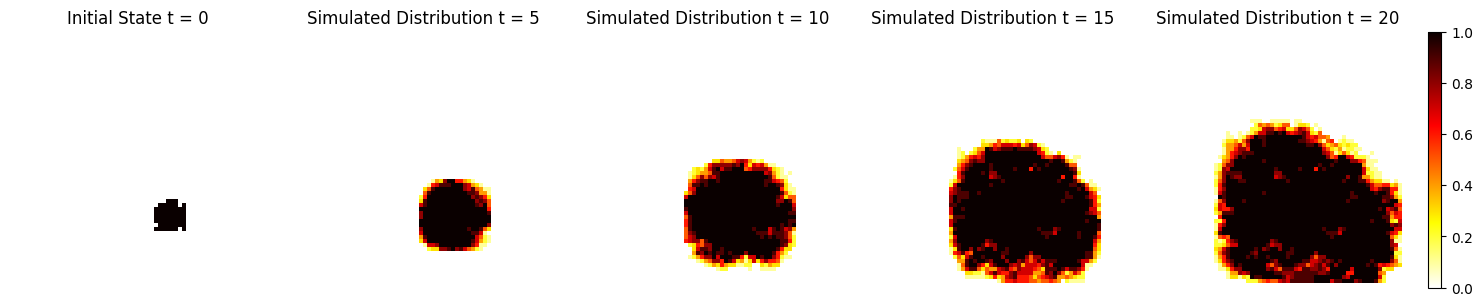

{'MSE': 0.04702636690970395, 'RMSE': 0.21685563610315492, 'MAE': 0.051074218630674295, 'Pearson Correlation': 0.4599920181470244, 'Spearman Correlation': 0.4225015187216335, 'SSIM': 0.8391925405661815, 'KL Divergence': 209.19999891764093, 'EMD (Wasserstein Distance)': 0.051074218630674295}
KL Divergence at t=5 : 0.046
{'MSE': 0.06584716767894863, 'RMSE': 0.256607029675628, 'MAE': 0.08103027344877774, 'Pearson Correlation': 0.6831152886465869, 'Spearman Correlation': 0.6556298168706451, 'SSIM': 0.7209601342054217, 'KL Divergence': 307.96776746225066, 'EMD (Wasserstein Distance)': 0.08049316395154164}
KL Divergence at t=10 : 0.045
{'MSE': 0.0867700189938478, 'RMSE': 0.2945675117759048, 'MAE': 0.11296386721114686, 'Pearson Correlation': 0.7465987140744613, 'Spearman Correlation': 0.7454328696538999, 'SSIM': 0.6466949153118, 'KL Divergence': 404.81237365236285, 'EMD (Wasserstein Distance)': 0.10979003874854243}
KL Divergence at t=15 : 0.048
{'MSE': 0.07400146456886436, 'RMSE': 0.2720321020

sampling loop time step: 100%|████████████████████████████████████████████████████████████| 500/500 [00:16<00:00, 30.73it/s]


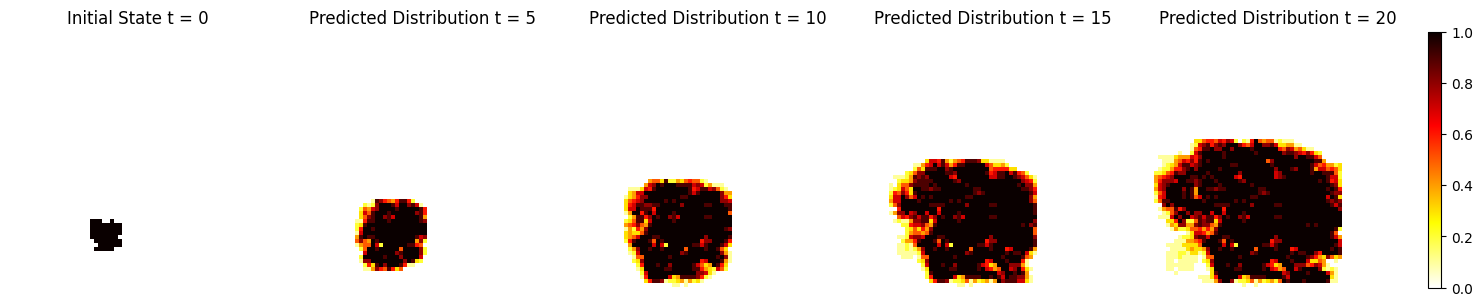

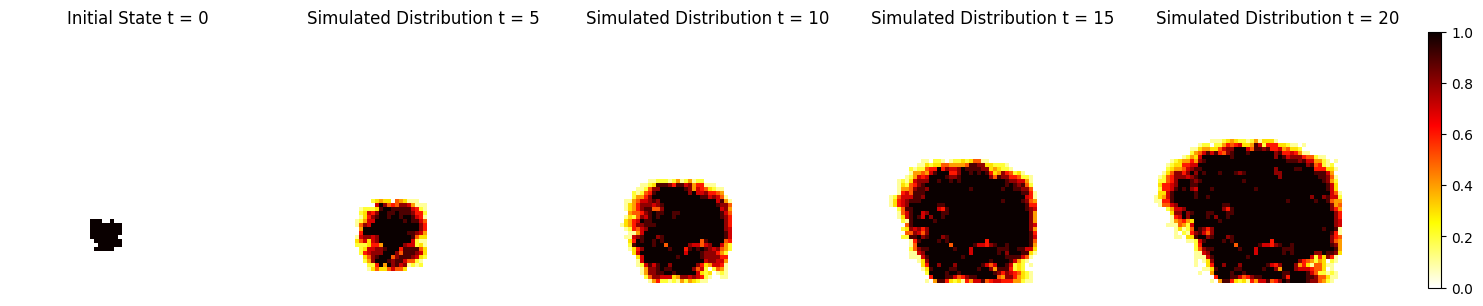

{'MSE': 0.03991699200269068, 'RMSE': 0.19979237223350316, 'MAE': 0.04501953120052349, 'Pearson Correlation': 0.4848032857198289, 'Spearman Correlation': 0.42841603760559466, 'SSIM': 0.8570969040267935, 'KL Divergence': 184.399999237068, 'EMD (Wasserstein Distance)': 0.04501953120052349}
KL Divergence at t=5 : 0.045
{'MSE': 0.06188232387779864, 'RMSE': 0.2487615803893331, 'MAE': 0.07907714832836063, 'Pearson Correlation': 0.6676151982407479, 'Spearman Correlation': 0.6686352620664701, 'SSIM': 0.7745079116956736, 'KL Divergence': 279.8494098550649, 'EMD (Wasserstein Distance)': 0.07854003890533931}
KL Divergence at t=10 : 0.045
{'MSE': 0.07062988239638801, 'RMSE': 0.26576283110395255, 'MAE': 0.09350585933207187, 'Pearson Correlation': 0.7567861629450339, 'Spearman Correlation': 0.7714459711120908, 'SSIM': 0.6991650359902059, 'KL Divergence': 316.93879212733543, 'EMD (Wasserstein Distance)': 0.0892578121718543}
KL Divergence at t=15 : 0.035
{'MSE': 0.08982910127531799, 'RMSE': 0.299715033

sampling loop time step: 100%|████████████████████████████████████████████████████████████| 500/500 [00:14<00:00, 33.75it/s]


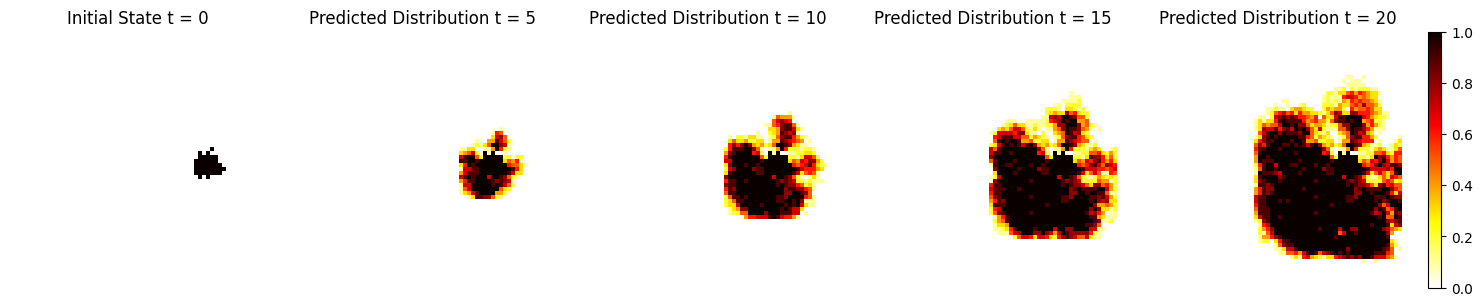

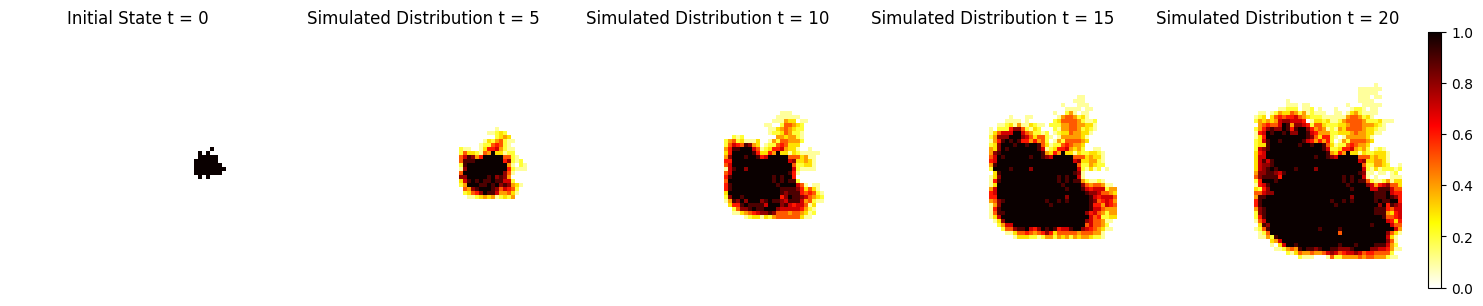

{'MSE': 0.018488769323375898, 'RMSE': 0.13597341403147858, 'MAE': 0.02380371087747335, 'Pearson Correlation': 0.5729279829764946, 'Spearman Correlation': 0.43898724241497306, 'SSIM': 0.8878975875698442, 'KL Divergence': 97.49999937261182, 'EMD (Wasserstein Distance)': 0.02380371087747335}
KL Divergence at t=5 : 0.035
{'MSE': 0.041279296682769216, 'RMSE': 0.20317307076177496, 'MAE': 0.056347656339130484, 'Pearson Correlation': 0.6419832243488166, 'Spearman Correlation': 0.6332307145416903, 'SSIM': 0.7941187905178042, 'KL Divergence': 217.1205613668658, 'EMD (Wasserstein Distance)': 0.05385742187027063}
KL Divergence at t=10 : 0.031
{'MSE': 0.06088867164849946, 'RMSE': 0.24675630011916505, 'MAE': 0.08754882824759988, 'Pearson Correlation': 0.7225575690624708, 'Spearman Correlation': 0.7149395472234467, 'SSIM': 0.7026393365131877, 'KL Divergence': 318.3328890015416, 'EMD (Wasserstein Distance)': 0.08330078120161488}
KL Divergence at t=15 : 0.041
{'MSE': 0.08218261677742707, 'RMSE': 0.2866

In [45]:
for i in range(1, 6):
    simulation_data = CondSeqImageDataset(os.path.join(DATA_DIR, f"state_{i}"), transform=transform)
    mean_preds = generate_predictions(simulation_data[0][1], diffusion)

    t_0 = simulation_data[0][1].squeeze().numpy()
    mean_preds = np.array(mean_preds)
    
    new_array_expanded = np.expand_dims(t_0, axis=0)
    mean_preds_total = np.concatenate((new_array_expanded, mean_preds), axis=0)
    
    plot_dist(mean_preds_total, type_output="prediction")
    mean_sim = calc_mean_dist_timesteps(simulation_data)
    plot_dist(mean_sim)

    for i in range(len(mean_preds)):
        d1 = mean_sim[i]
        d2 = mean_preds[i]
        print(compare_probability_maps(d2, d1))
        print(f"KL Divergence at t={(i+1)*5} : {np.round(kl_divergence(d1, d2), 3)}")